In [1]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import time
import data_processing
import gc
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

/afs/inf.ed.ac.uk/user/s16/s1688201/miniconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/afs/inf.ed.ac.uk/user/s16/s1688201/miniconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/afs/inf.ed.ac.uk/user/s16/s1688201/miniconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", n

In [2]:
'''
num_hidden_1=155,
num_hidden_2=81,
num_hidden_3=27,
num_hidden_4=9,
num_hidden_5=3,

'''

class autoencoder(object):# 155 27 128 101 74
    def __init__(self,num_epochs=100, display_step=100, learning_rate=0.1, batch_size=100,
                 denoising=False, new_poll_weight=0.002,masking=0, num_layers=3, num_hidden_1=155,
                 num_hidden_2=81,num_hidden_3=27,num_hidden_4=9,num_hidden_5=3,continue_from_saved=False, time_decay=1):

        self.data_provider = data_processing.data_provider('/afs/inf.ed.ac.uk/user/s16/s1688201/Desktop/my_honours_project/this_that.json')
        self.data_provider.parse()
        # Interactions are fed as binary but using decimal helps with adding 2 interactions together
        self.interaction_dict = {'skips': 16,
            'owns': 8,
            'tracks': 4,
            'comment': 2,
            'vote': 1
        }

        self.polls = self.data_provider.polls  # [:50]
        self.num_engagements = len(self.interaction_dict)

        self.num_input = len(self.polls) * self.num_engagements
        tf.set_random_seed(1)

        self.users = self.data_provider.users#[:50]

        self.test_polls = self.data_provider.polls#[500:]
        self.num_epochs = num_epochs # initial training eppchs given training data
        self.display_step = display_step # display training loss every x epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.denoising = denoising # whether to add noise to the input vectors - might help with accidental interactions
        self.new_poll_weight = new_poll_weight # How much weight new polls are given in the output layer (gives new polls some initial traction)
        self.masking = masking # TODO: Add masking to data to make synthetic users with less interactions and see if it helps
        self.num_layers = num_layers
        self.num_hidden_1 = num_hidden_1
        self.num_hidden_2 = num_hidden_2
        self.num_hidden_3 = num_hidden_3
        self.num_hidden_4 = num_hidden_4
        self.num_hidden_5 = num_hidden_5
        self.continue_from_saved = continue_from_saved
        self.train= self.data_provider.train
        self.test = self.data_provider.test
        self.validation = self.data_provider.validation
        self.test_users = []
        self.time_decay = time_decay
        self.X = tf.compat.v1.placeholder("float", [None, None])
        self.Y = tf.compat.v1.placeholder("float", [None, None])
        self.saver = None

        self.compressed_train = []
        self.compressed_test = []

        self.weights2 = {
            'encoder_h1': tf.Variable(tf.random_normal([self.num_input, self.num_hidden_1])),
            'encoder_h2': tf.Variable(tf.random_normal([self.num_hidden_1, self.num_hidden_2])),
            'encoder_h3': tf.Variable(tf.random_normal([self.num_hidden_2, self.num_hidden_3])),
            'encoder_h4': tf.Variable(tf.random_normal([self.num_hidden_3, self.num_hidden_4])),
            'encoder_h5': tf.Variable(tf.random_normal([self.num_hidden_4, self.num_hidden_5])),

            'decoder_h1': tf.Variable(tf.random_normal([self.num_hidden_2, self.num_hidden_1])),
            'decoder_h2': tf.Variable(tf.random_normal([self.num_hidden_1, self.num_input])),
            'decoder_h3': tf.Variable(tf.random_normal([self.num_hidden_3, self.num_hidden_2])),
            'decoder_h4': tf.Variable(tf.random_normal([self.num_hidden_2, self.num_hidden_1])),
            'decoder_h5': tf.Variable(tf.random_normal([self.num_hidden_1, self.num_input])),
        }
        self.biases2 = {
            'encoder_b1': tf.Variable(tf.random_normal([self.num_hidden_1])),
            'encoder_b2': tf.Variable(tf.random_normal([self.num_hidden_2])),
            'encoder_b3': tf.Variable(tf.random_normal([self.num_hidden_3])),

            'encoder_b4': tf.Variable(tf.random_normal([self.num_hidden_4])),
            'encoder_b5': tf.Variable(tf.random_normal([self.num_hidden_5])),

            'decoder_b1': tf.Variable(tf.random_normal([self.num_hidden_1])),
            'decoder_b2': tf.Variable(tf.random_normal([self.num_input])),
            'decoder_b3': tf.Variable(tf.random_normal([self.num_hidden_2])),
            'decoder_b4': tf.Variable(tf.random_normal([self.num_hidden_1])),
            'decoder_b5': tf.Variable(tf.random_normal([self.num_input])),

        }


        self.encoder_op = self.encoder(self.X)
        self.decoder_op = self.decoder(self.encoder_op)
        self.setup_graph()

        self.train_and_predict()

    def encoder(self, x):
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, self.weights2['encoder_h1']),self.biases2['encoder_b1']))
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights2['encoder_h2']),self.biases2['encoder_b2']))
        #layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, self.weights2['encoder_h3']), self.biases2['encoder_b3']))
        #layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, self.weights2['encoder_h4']), self.biases2['encoder_b4']))
        #layer_5 = tf.nn.sigmoid(tf.add(tf.matmul(layer_4, self.weights2['encoder_h5']), self.biases2['encoder_b5']))
        return layer_2

    def decoder(self, x):
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, self.weights2['decoder_h1']), self.biases2['decoder_b1']))
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights2['decoder_h2']),self.biases2['decoder_b2']))
        #layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, self.weights2['decoder_h1']), self.biases2['decoder_b1']))
        #layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights2['decoder_h2']),self.biases2['decoder_b2']))
        #layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, self.weights2['decoder_h3']), self.biases2['decoder_b3']))
        #layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, self.weights2['decoder_h4']), self.biases2['decoder_b4']))
        #layer_5 = tf.nn.sigmoid(tf.add(tf.matmul(layer_4, self.weights2['decoder_h5']), self.biases2['decoder_b5']))
        return layer_2

    def setup_graph(self):

        # Prediction
        self.y_pred = self.decoder_op

        self.y_true = self.Y
        self.loss = self._loss()
        self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)

        self.init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()

    def _loss(self):
        return tf.reduce_mean(tf.pow(self.y_true - self.y_pred, 2))

    def train_and_predict(self, save=True):
        gc.collect()

        f = open("guru99.txt", "w+")

        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            train_loss = []
            validation_loss = []
            t0 = time.time()

            for i in range(0,self.num_epochs):

                batch_x = self.train[np.random.choice(self.train.shape[0], self.batch_size, replace=True), :]
                batch_y = np.copy(batch_x)

                _, l = sess.run([self.optimizer, self.loss], feed_dict={self.X: batch_x, self.Y: batch_y})
                train_loss.append(l)


                # print("the minibatch loss for epoch %d is %f"% (i,l));

                f.write("%f\r\n" % l)

                l = sess.run(self.loss, feed_dict={self.X: self.validation, self.Y: self.validation})
                validation_loss.append(l)
                if save and (i == 0 or i % self.display_step == 0):
                    self.saver.save(sess, 'refactored/model.ckpt')

            train_encoder_result = sess.run(self.encoder_op, feed_dict={self.X: self.train})
            test_encoder_result = sess.run(self.encoder_op, feed_dict={self.X: self.test})

            print()

            self.compressed_train = np.copy(train_encoder_result)
            self.compressed_test = np.copy(test_encoder_result)
            # print(test_encoder_result)

            xs = np.arange(1,self.num_epochs+1,1)
            ys = train_loss
            fig, ax = plt.subplots(figsize=(12, 8))
            ax.plot(xs, ys,color = 'b')
            xs = np.arange(1, self.num_epochs+1, 1)
            ys = validation_loss
            plt.plot(xs, ys,color = 'r')
            plt.show()

            print('autoencoder finished')
        sess.close()


In [3]:
def binary_to_dec(recommendering_user):
    dec_array = []
    for i in range(636):
        first = i * 5
        second = i * 5 + 1
        third = i * 5 + 2
        fourth = i * 5 + 3
        fifth = i * 5 + 4

        value = recommendering_user[first] * (2 ** 4) + recommendering_user[second] * (2 ** 3) + \
                recommendering_user[third] * (2 ** 2) + recommendering_user[fourth] * (2 ** 1) + recommendering_user[fifth]

        dec_array.append(value)

    return dec_array

def binary_matrix_to_dec_matrix(recommendering_user):
    result = []
    for i in range(len(recommendering_user)):
        result.append( binary_to_dec(recommendering_user[i]) )
    return result
                                                        # true_positive,false_negative,false_positive
def loss_function_accuracy_difference_between_true_label_and_probability(training_data_accuracy,true_label,true_positive,false_negative,false_positive):

    if true_label == 16 :
        normalised_true_label = 0
    else:
        normalised_true_label = 1
    result = np.abs((training_data_accuracy-normalised_true_label))

    # prediction is 1 whereas true label is 1
    if training_data_accuracy > 0.5 and normalised_true_label == 1:
        true_positive = true_positive + 1

    if training_data_accuracy < 0.5 and normalised_true_label == 1:
        false_negative = false_negative + 1

    if training_data_accuracy > 0.5 and normalised_true_label == 0:
        false_positive = false_positive+1

    return result,true_positive,false_negative,false_positive

def loss_function_accuracy_difference_between_true_label_and_prediction(training_data_accuracy,true_label,true_positive,false_negative,false_positive):
    if true_label == 16 :
        normalised_true_label = 0
    else:
        normalised_true_label = 1

    if training_data_accuracy>0.5:
        predicted_value = 1
    else:
        predicted_value = 0
    result = np.abs((normalised_true_label-predicted_value))

    # prediction is 1 whereas true label is 1
    if training_data_accuracy > 0.5 and normalised_true_label == 1:
        true_positive = true_positive + 1

    if training_data_accuracy < 0.5 and normalised_true_label == 1:
        false_negative = false_negative + 1

    if training_data_accuracy > 0.5 and normalised_true_label == 0:
        false_positive = false_positive + 1

    return result,true_positive,false_negative,false_positive

def fill_the_clusters(label_pred):
    clusters = {}
    for index, cluster_index in enumerate(label_pred):
        if cluster_index not in clusters.keys():
            clusters[cluster_index] = [ original_training_data[index] ]
        else:
            clusters[cluster_index].append(original_training_data[index])
    return clusters

def run_kmeans(n_clusters):
    clusters = {}
    estimator = KMeans(n_clusters=n_clusters)
    estimator.fit(compressed_training_data)
    label_pred = estimator.labels_
    centroids = estimator.cluster_centers_
    centroids = np.asarray(centroids)

    return estimator,label_pred,centroids

def calculate_loss(clusters):

    loss_difference_between_true_label_and_probability = []
    loss_difference_between_true_label_and_prediction = []


    true_positive_1 = 0
    false_negative_1 = 0
    false_positive_1 = 0

    for i in range( len(compressed_testing_data) ):# for every test case

        label = estimator.predict(np.reshape(compressed_testing_data[i],(1,-1)))

        tempt = np.copy( clusters[label[0]] )

        recommendering_user_binary = np.copy(original_testing_data[i])

        recommendering_user = binary_to_dec(recommendering_user_binary)

        new_matrix = binary_matrix_to_dec_matrix( tempt )

        row_index = np.shape(new_matrix)[0]

        poll_num = len(recommendering_user)

        individual_accuracy_1 = []
        individual_accuracy_2 = []

        true_positive_1 = 0
        false_negative_1 = 0
        false_positive_1 = 0

        true_positive_2 = 0
        false_negative_2 = 0
        false_positive_2 = 0

        for j in range(poll_num): # for every poll of this test user
            true_label =recommendering_user[j]

            true = 0
            training_count = 0


            if recommendering_user[j] != 0 :
                for k in range(row_index):
                    new_matrix = np.asarray(new_matrix)
                    column = new_matrix[:,j]

                    # 16 means the user skips the poll
                    if column[k] != 16 and column[k] != 0:
                        true = true + 1
                    if column[k] !=0:
                        training_count = training_count+1

                if training_count != 0 and recommendering_user[j] != 0:
                    training_data_accuracy = true/training_count

                    the_loss_of_each_poll_1,true_positive_1,false_negative_1,false_positive_1 = loss_function_accuracy_difference_between_true_label_and_probability(training_data_accuracy,true_label,true_positive_1,false_negative_1,false_positive_1)
                    the_loss_of_each_poll_2, true_positive_2, false_negative_2, false_positive_2 = loss_function_accuracy_difference_between_true_label_and_prediction(training_data_accuracy, true_label, true_positive_2, false_negative_2, false_positive_2)

                    individual_accuracy_1.append(the_loss_of_each_poll_1)
                    individual_accuracy_2.append(the_loss_of_each_poll_2)

        the_loss_of_a_user_1 = np.average(individual_accuracy_1)
        the_loss_of_a_user_2 = np.average(individual_accuracy_2)
        loss_difference_between_true_label_and_probability.append(the_loss_of_a_user_1)
        loss_difference_between_true_label_and_prediction.append(the_loss_of_a_user_2)

    return loss_difference_between_true_label_and_probability,true_positive_1,false_negative_1,false_positive_1,loss_difference_between_true_label_and_prediction, true_positive_2, false_negative_2, false_positive_2


def number_of_zero_one_16(column):

    zero = 0
    one = 0
    sixteen =0
    for i in column:
        if i == 0:
            zero = zero + 1

        if i ==16:
            sixteen = sixteen + 1
        else:
            one = one + 1
    print("there are %d non interactions, %d interactions, %d skips"% (zero,one,sixteen))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



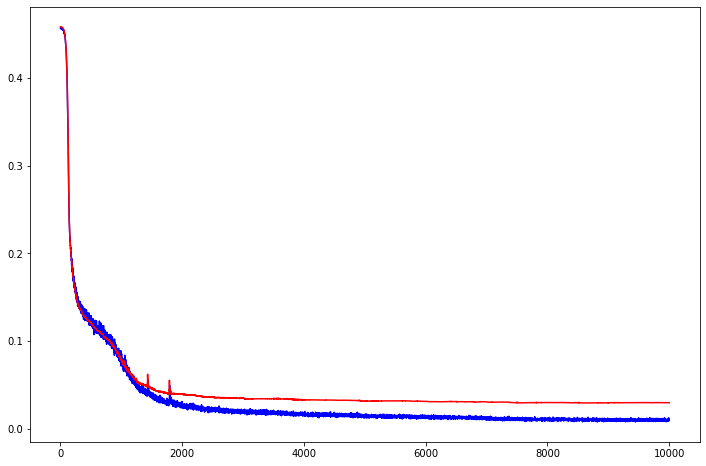

autoencoder finished


"\nfig, ax = plt.subplots(figsize=(12, 8))\nprecision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))\nax.plot(xs, precision_list_2)\ncx.set_xlabel('the value of k')\ncx.set_ylabel('precision_2')\n"

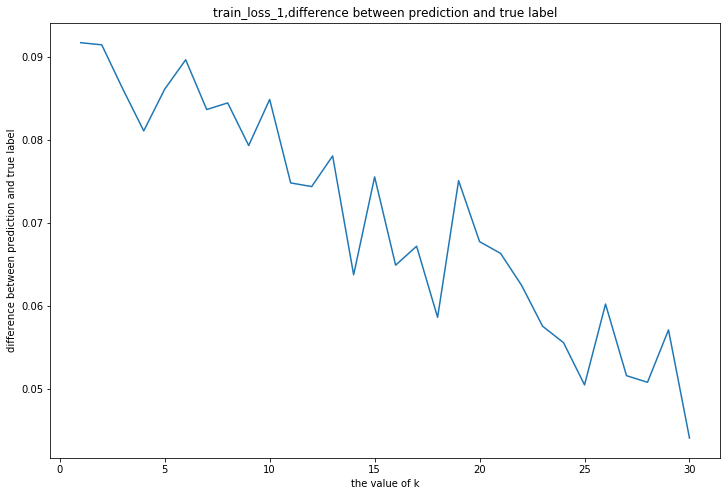

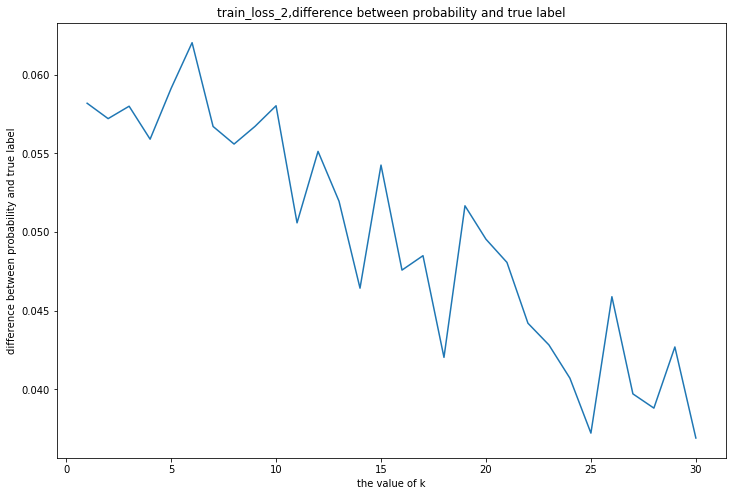

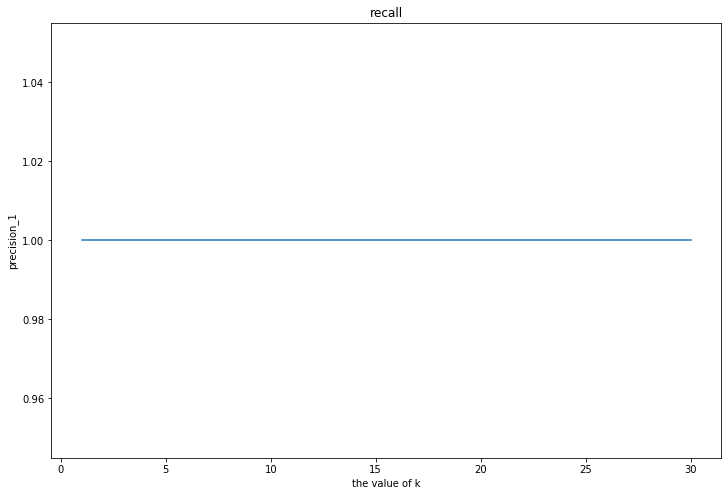

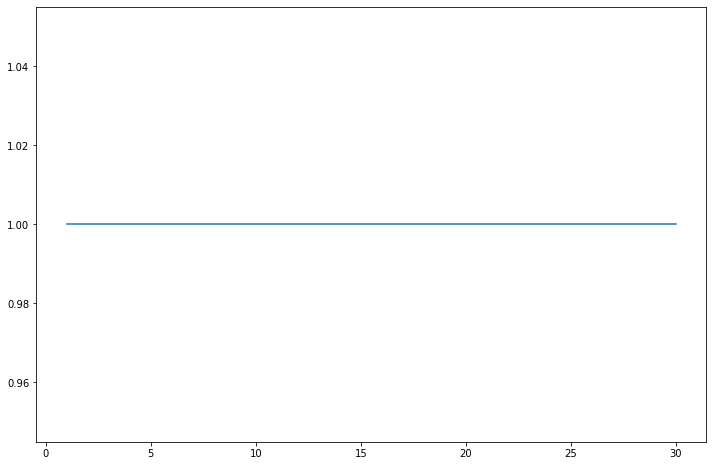

In [4]:
a = autoencoder(num_epochs=10000, denoising=False, masking=0.5, display_step=200)

compressed_training_data = a.compressed_train

original_training_data = a.train

compressed_testing_data = a.compressed_test
original_testing_data = a.test




overall_true_positive = 0
overall_false_negative = 0
overall_false_positive = 0

#n_clusters =20
range_of_cluster = 30
train_loss_1 = []
train_loss_2 = []

recall_list_1 = []
precision_list_1 = []

recall_list_2 = []
precision_list_2 = []

for n_clusters in np.arange(1,range_of_cluster+1):

    estimator,label_pred,centroids = run_kmeans(n_clusters)

    clusters = fill_the_clusters(label_pred)

    loss_difference_between_true_label_and_probability, true_positive_1, false_negative_1, false_positive_1,loss_difference_between_true_label_and_prediction, true_positive_2, false_negative_2, false_positive_2 = calculate_loss(clusters)

    recall_1 = true_positive_1/(true_positive_1+false_negative_1)
    precision_1 = true_positive_1/(true_positive_1+false_positive_1)
    recall_list_1.append(recall_1)
    precision_list_1.append(precision_1)

    recall_2 = true_positive_2 / (true_positive_2 + false_negative_2)
    precision_2 = true_positive_2 / (true_positive_2 + false_positive_2)
    recall_list_2.append(recall_2)
    precision_list_2.append(precision_2)

    l = np.average(loss_difference_between_true_label_and_probability)

    train_loss_1.append(np.average(loss_difference_between_true_label_and_probability))
    train_loss_2.append(np.average(loss_difference_between_true_label_and_prediction))


xs = np.arange(1,range_of_cluster+1)
fig, ax = plt.subplots(figsize=(12, 8))
train_loss_1 = np.reshape(train_loss_1,(range_of_cluster,-1))
ax.plot(xs, train_loss_1)
ax.set_xlabel('the value of k')
ax.set_ylabel('difference between prediction and true label')
ax.title.set_text('train_loss_1,difference between prediction and true label')

fig, bx = plt.subplots(figsize=(12, 8))
train_loss_2 = np.reshape(train_loss_2,(range_of_cluster,-1))
bx.plot(xs, train_loss_2)
bx.set_xlabel('the value of k')
bx.set_ylabel('difference between probability and true label')
bx.title.set_text('train_loss_2,difference between probability and true label')

fig, cx = plt.subplots(figsize=(12, 8))
recall_list_1 = np.reshape(recall_list_1,(range_of_cluster,-1))
cx.plot(xs, recall_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('recall_loss_function1')
cx.title.set_text('recall')
# fig, cx = plt.subplots(figsize=(12, 8))
# recall_list_2 = np.reshape(recall_list_2,(range_of_cluster,-1))
# cx.plot(xs, recall_list_2)
# cx.set_xlabel('the value of k')
# cx.set_ylabel('recall_2')

fig, ax = plt.subplots(figsize=(12, 8))
precision_list_1 = np.reshape(precision_list_1,(range_of_cluster,-1))
ax.plot(xs, precision_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_1')

'''
fig, ax = plt.subplots(figsize=(12, 8))
precision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))
ax.plot(xs, precision_list_2)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_2')
'''


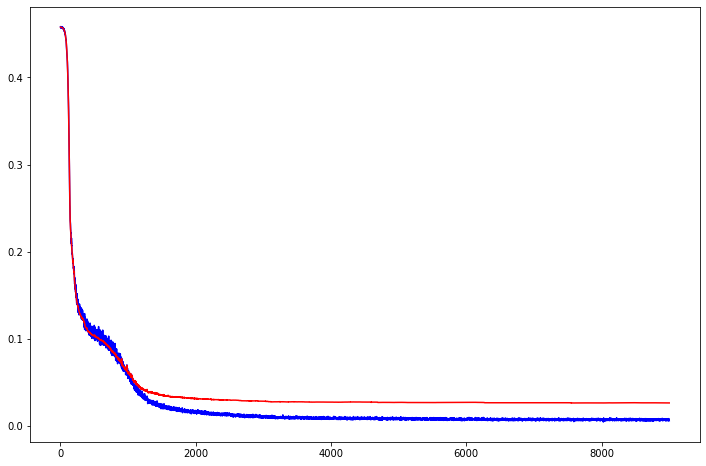

autoencoder finished


"\nfig, ax = plt.subplots(figsize=(12, 8))\nprecision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))\nax.plot(xs, precision_list_2)\ncx.set_xlabel('the value of k')\ncx.set_ylabel('precision_2')\n"

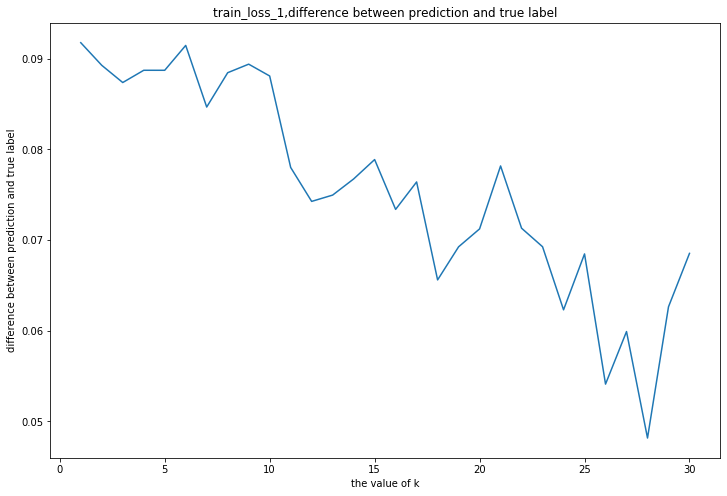

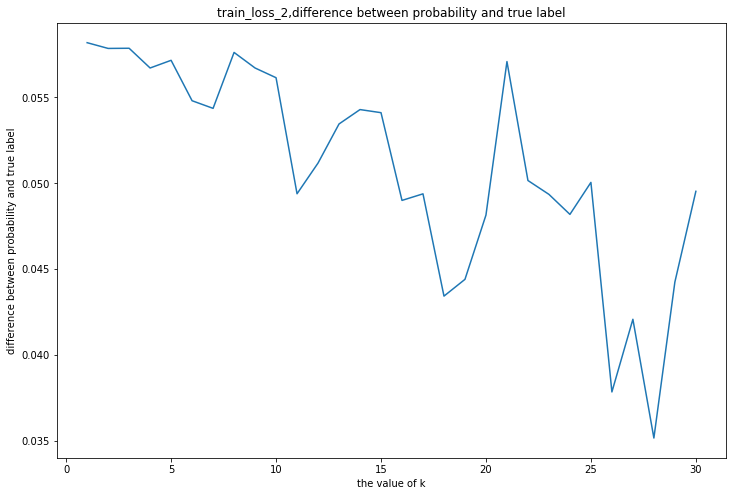

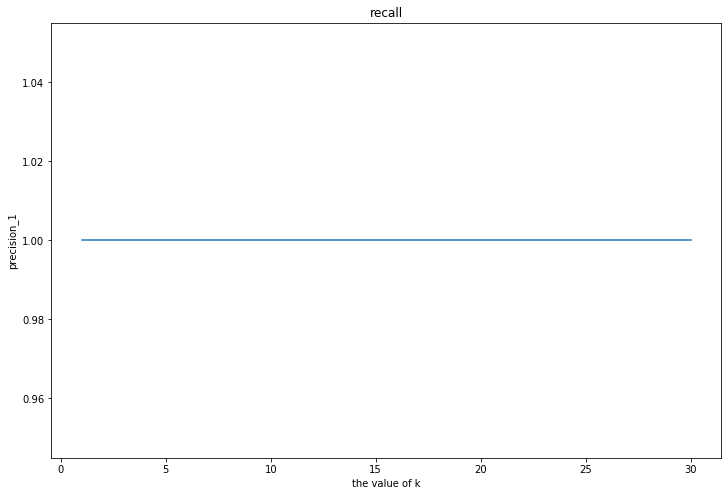

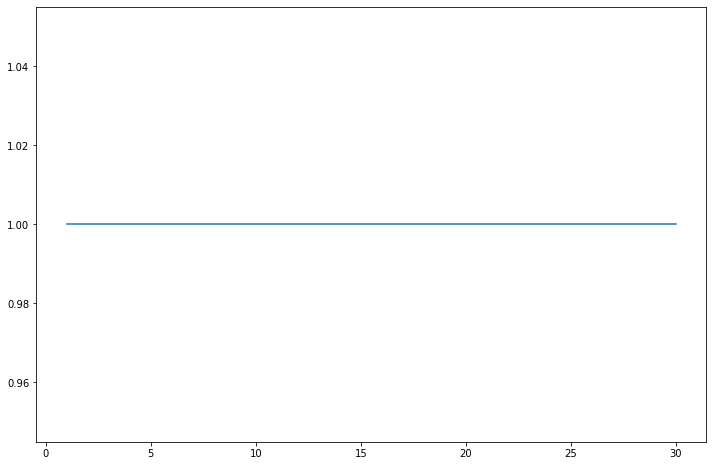

In [5]:
a = autoencoder(num_epochs=9000, denoising=False, masking=0.5, display_step=200)

compressed_training_data = a.compressed_train

original_training_data = a.train

compressed_testing_data = a.compressed_test
original_testing_data = a.test




overall_true_positive = 0
overall_false_negative = 0
overall_false_positive = 0

#n_clusters =20
range_of_cluster = 30
train_loss_1 = []
train_loss_2 = []

recall_list_1 = []
precision_list_1 = []

recall_list_2 = []
precision_list_2 = []

for n_clusters in np.arange(1,range_of_cluster+1):

    estimator,label_pred,centroids = run_kmeans(n_clusters)

    clusters = fill_the_clusters(label_pred)

    loss_difference_between_true_label_and_probability, true_positive_1, false_negative_1, false_positive_1,loss_difference_between_true_label_and_prediction, true_positive_2, false_negative_2, false_positive_2 = calculate_loss(clusters)

    recall_1 = true_positive_1/(true_positive_1+false_negative_1)
    precision_1 = true_positive_1/(true_positive_1+false_positive_1)
    recall_list_1.append(recall_1)
    precision_list_1.append(precision_1)

    recall_2 = true_positive_2 / (true_positive_2 + false_negative_2)
    precision_2 = true_positive_2 / (true_positive_2 + false_positive_2)
    recall_list_2.append(recall_2)
    precision_list_2.append(precision_2)

    l = np.average(loss_difference_between_true_label_and_probability)

    train_loss_1.append(np.average(loss_difference_between_true_label_and_probability))
    train_loss_2.append(np.average(loss_difference_between_true_label_and_prediction))


xs = np.arange(1,range_of_cluster+1)
fig, ax = plt.subplots(figsize=(12, 8))
train_loss_1 = np.reshape(train_loss_1,(range_of_cluster,-1))
ax.plot(xs, train_loss_1)
ax.set_xlabel('the value of k')
ax.set_ylabel('difference between prediction and true label')
ax.title.set_text('train_loss_1,difference between prediction and true label')

fig, bx = plt.subplots(figsize=(12, 8))
train_loss_2 = np.reshape(train_loss_2,(range_of_cluster,-1))
bx.plot(xs, train_loss_2)
bx.set_xlabel('the value of k')
bx.set_ylabel('difference between probability and true label')
bx.title.set_text('train_loss_2,difference between probability and true label')

fig, cx = plt.subplots(figsize=(12, 8))
recall_list_1 = np.reshape(recall_list_1,(range_of_cluster,-1))
cx.plot(xs, recall_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('recall_loss_function1')
cx.title.set_text('recall')
# fig, cx = plt.subplots(figsize=(12, 8))
# recall_list_2 = np.reshape(recall_list_2,(range_of_cluster,-1))
# cx.plot(xs, recall_list_2)
# cx.set_xlabel('the value of k')
# cx.set_ylabel('recall_2')

fig, ax = plt.subplots(figsize=(12, 8))
precision_list_1 = np.reshape(precision_list_1,(range_of_cluster,-1))
ax.plot(xs, precision_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_1')

'''
fig, ax = plt.subplots(figsize=(12, 8))
precision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))
ax.plot(xs, precision_list_2)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_2')
'''



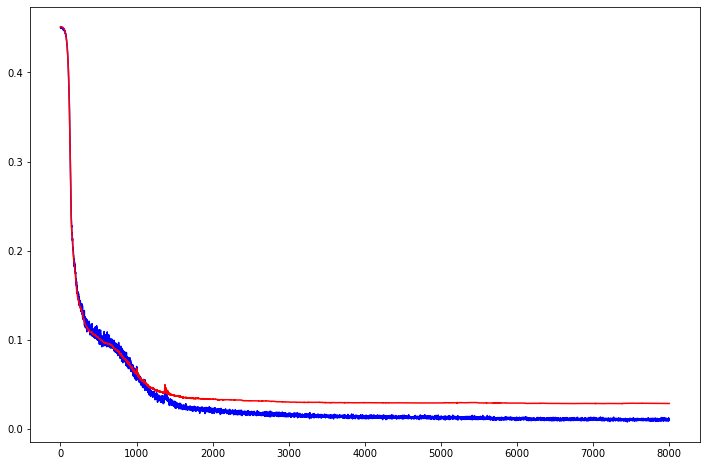

autoencoder finished


"\nfig, ax = plt.subplots(figsize=(12, 8))\nprecision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))\nax.plot(xs, precision_list_2)\ncx.set_xlabel('the value of k')\ncx.set_ylabel('precision_2')\n"

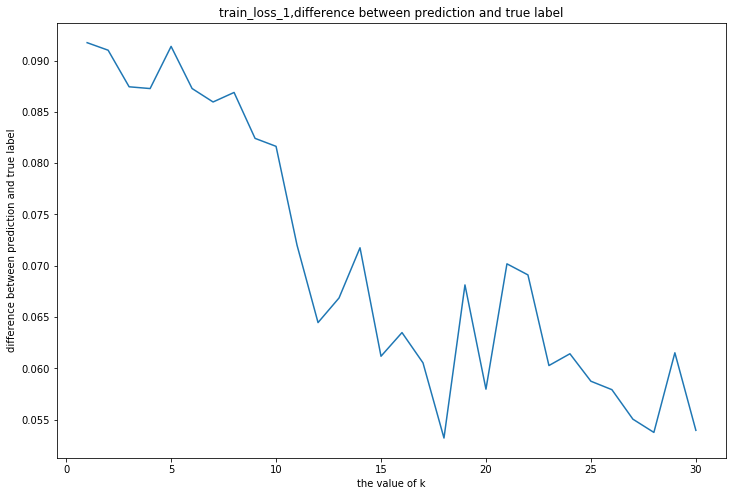

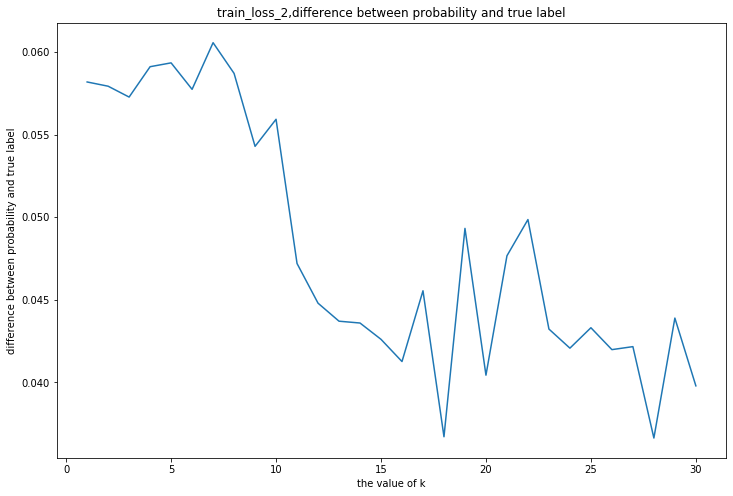

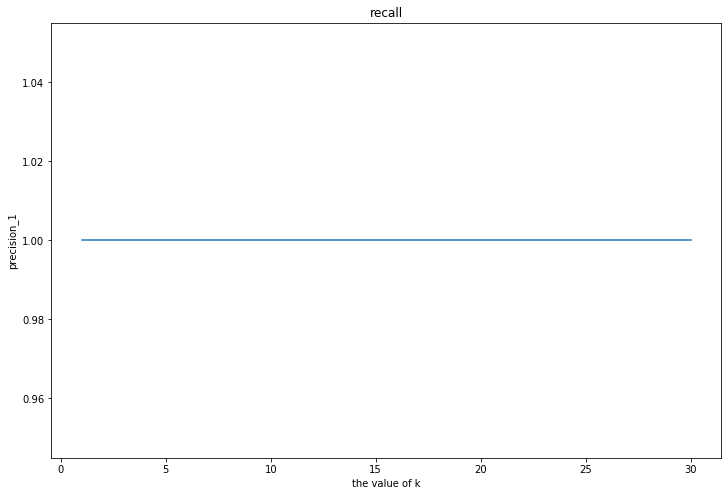

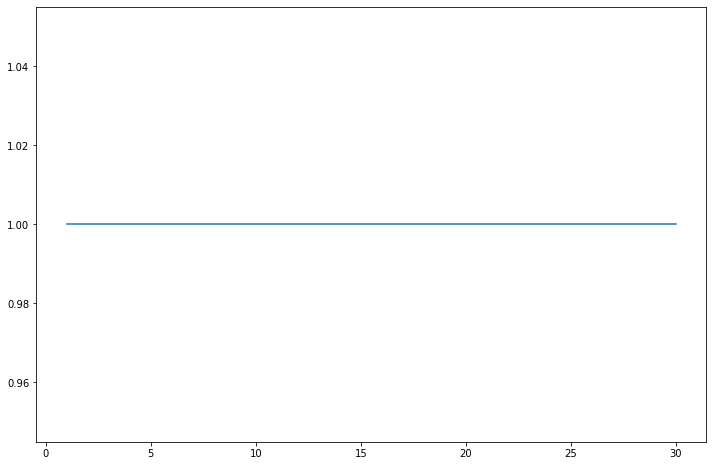

In [6]:
a = autoencoder(num_epochs=8000, denoising=False, masking=0.5, display_step=200)

compressed_training_data = a.compressed_train

original_training_data = a.train

compressed_testing_data = a.compressed_test
original_testing_data = a.test




overall_true_positive = 0
overall_false_negative = 0
overall_false_positive = 0

#n_clusters =20
range_of_cluster = 30
train_loss_1 = []
train_loss_2 = []

recall_list_1 = []
precision_list_1 = []

recall_list_2 = []
precision_list_2 = []

for n_clusters in np.arange(1,range_of_cluster+1):

    estimator,label_pred,centroids = run_kmeans(n_clusters)

    clusters = fill_the_clusters(label_pred)

    loss_difference_between_true_label_and_probability, true_positive_1, false_negative_1, false_positive_1,loss_difference_between_true_label_and_prediction, true_positive_2, false_negative_2, false_positive_2 = calculate_loss(clusters)

    recall_1 = true_positive_1/(true_positive_1+false_negative_1)
    precision_1 = true_positive_1/(true_positive_1+false_positive_1)
    recall_list_1.append(recall_1)
    precision_list_1.append(precision_1)

    recall_2 = true_positive_2 / (true_positive_2 + false_negative_2)
    precision_2 = true_positive_2 / (true_positive_2 + false_positive_2)
    recall_list_2.append(recall_2)
    precision_list_2.append(precision_2)

    l = np.average(loss_difference_between_true_label_and_probability)

    train_loss_1.append(np.average(loss_difference_between_true_label_and_probability))
    train_loss_2.append(np.average(loss_difference_between_true_label_and_prediction))


xs = np.arange(1,range_of_cluster+1)
fig, ax = plt.subplots(figsize=(12, 8))
train_loss_1 = np.reshape(train_loss_1,(range_of_cluster,-1))
ax.plot(xs, train_loss_1)
ax.set_xlabel('the value of k')
ax.set_ylabel('difference between prediction and true label')
ax.title.set_text('train_loss_1,difference between prediction and true label')

fig, bx = plt.subplots(figsize=(12, 8))
train_loss_2 = np.reshape(train_loss_2,(range_of_cluster,-1))
bx.plot(xs, train_loss_2)
bx.set_xlabel('the value of k')
bx.set_ylabel('difference between probability and true label')
bx.title.set_text('train_loss_2,difference between probability and true label')

fig, cx = plt.subplots(figsize=(12, 8))
recall_list_1 = np.reshape(recall_list_1,(range_of_cluster,-1))
cx.plot(xs, recall_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('recall_loss_function1')
cx.title.set_text('recall')
# fig, cx = plt.subplots(figsize=(12, 8))
# recall_list_2 = np.reshape(recall_list_2,(range_of_cluster,-1))
# cx.plot(xs, recall_list_2)
# cx.set_xlabel('the value of k')
# cx.set_ylabel('recall_2')

fig, ax = plt.subplots(figsize=(12, 8))
precision_list_1 = np.reshape(precision_list_1,(range_of_cluster,-1))
ax.plot(xs, precision_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_1')

'''
fig, ax = plt.subplots(figsize=(12, 8))
precision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))
ax.plot(xs, precision_list_2)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_2')
'''



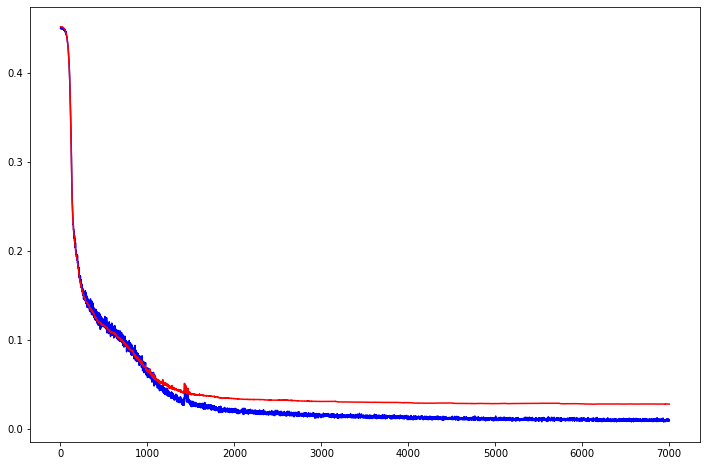

autoencoder finished


"\nfig, ax = plt.subplots(figsize=(12, 8))\nprecision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))\nax.plot(xs, precision_list_2)\ncx.set_xlabel('the value of k')\ncx.set_ylabel('precision_2')\n"

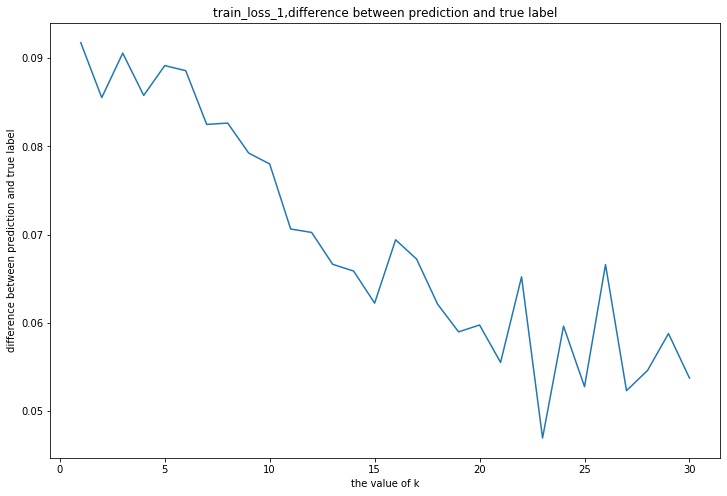

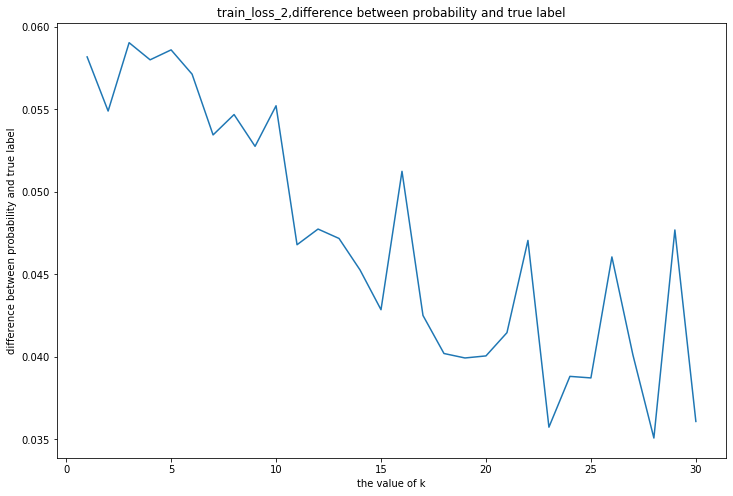

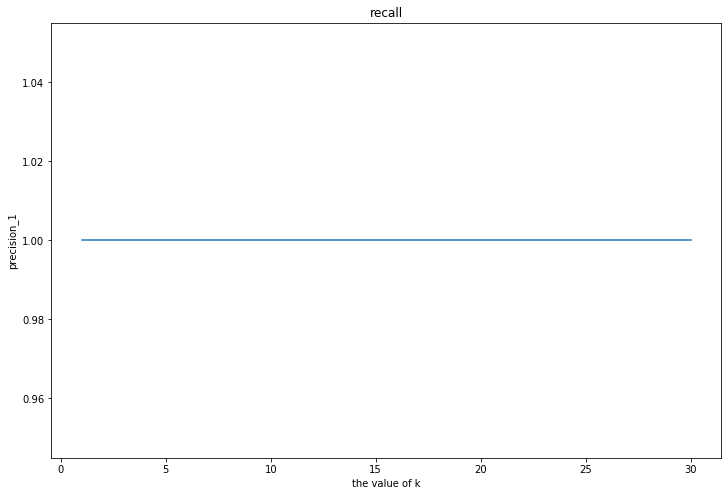

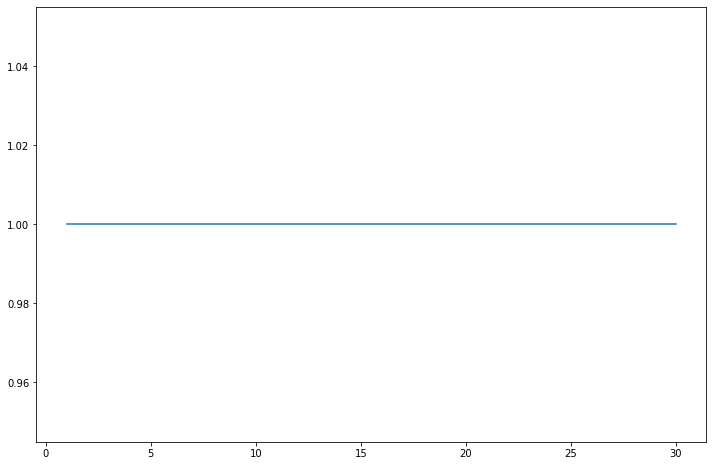

In [7]:
a = autoencoder(num_epochs=7000, denoising=False, masking=0.5, display_step=200)

compressed_training_data = a.compressed_train

original_training_data = a.train

compressed_testing_data = a.compressed_test
original_testing_data = a.test




overall_true_positive = 0
overall_false_negative = 0
overall_false_positive = 0

#n_clusters =20
range_of_cluster = 30
train_loss_1 = []
train_loss_2 = []

recall_list_1 = []
precision_list_1 = []

recall_list_2 = []
precision_list_2 = []

for n_clusters in np.arange(1,range_of_cluster+1):

    estimator,label_pred,centroids = run_kmeans(n_clusters)

    clusters = fill_the_clusters(label_pred)

    loss_difference_between_true_label_and_probability, true_positive_1, false_negative_1, false_positive_1,loss_difference_between_true_label_and_prediction, true_positive_2, false_negative_2, false_positive_2 = calculate_loss(clusters)

    recall_1 = true_positive_1/(true_positive_1+false_negative_1)
    precision_1 = true_positive_1/(true_positive_1+false_positive_1)
    recall_list_1.append(recall_1)
    precision_list_1.append(precision_1)

    recall_2 = true_positive_2 / (true_positive_2 + false_negative_2)
    precision_2 = true_positive_2 / (true_positive_2 + false_positive_2)
    recall_list_2.append(recall_2)
    precision_list_2.append(precision_2)

    l = np.average(loss_difference_between_true_label_and_probability)

    train_loss_1.append(np.average(loss_difference_between_true_label_and_probability))
    train_loss_2.append(np.average(loss_difference_between_true_label_and_prediction))


xs = np.arange(1,range_of_cluster+1)
fig, ax = plt.subplots(figsize=(12, 8))
train_loss_1 = np.reshape(train_loss_1,(range_of_cluster,-1))
ax.plot(xs, train_loss_1)
ax.set_xlabel('the value of k')
ax.set_ylabel('difference between prediction and true label')
ax.title.set_text('train_loss_1,difference between prediction and true label')

fig, bx = plt.subplots(figsize=(12, 8))
train_loss_2 = np.reshape(train_loss_2,(range_of_cluster,-1))
bx.plot(xs, train_loss_2)
bx.set_xlabel('the value of k')
bx.set_ylabel('difference between probability and true label')
bx.title.set_text('train_loss_2,difference between probability and true label')

fig, cx = plt.subplots(figsize=(12, 8))
recall_list_1 = np.reshape(recall_list_1,(range_of_cluster,-1))
cx.plot(xs, recall_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('recall_loss_function1')
cx.title.set_text('recall')
# fig, cx = plt.subplots(figsize=(12, 8))
# recall_list_2 = np.reshape(recall_list_2,(range_of_cluster,-1))
# cx.plot(xs, recall_list_2)
# cx.set_xlabel('the value of k')
# cx.set_ylabel('recall_2')

fig, ax = plt.subplots(figsize=(12, 8))
precision_list_1 = np.reshape(precision_list_1,(range_of_cluster,-1))
ax.plot(xs, precision_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_1')

'''
fig, ax = plt.subplots(figsize=(12, 8))
precision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))
ax.plot(xs, precision_list_2)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_2')
'''



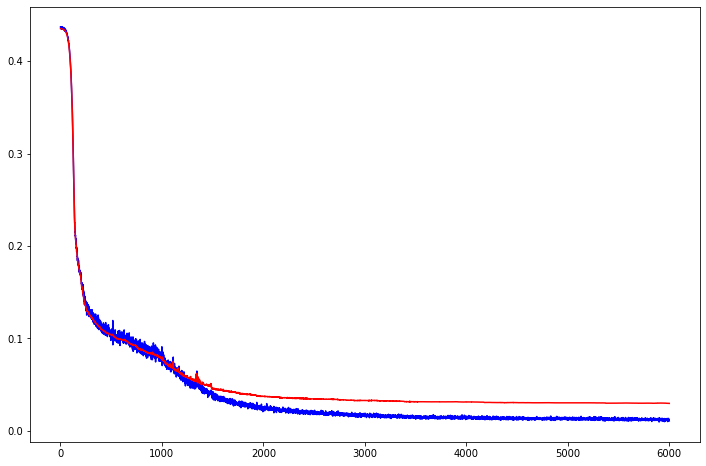

autoencoder finished


"\nfig, ax = plt.subplots(figsize=(12, 8))\nprecision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))\nax.plot(xs, precision_list_2)\ncx.set_xlabel('the value of k')\ncx.set_ylabel('precision_2')\n"

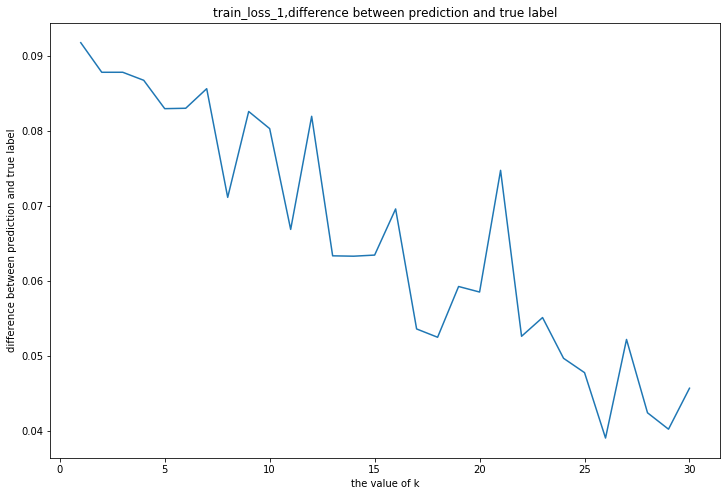

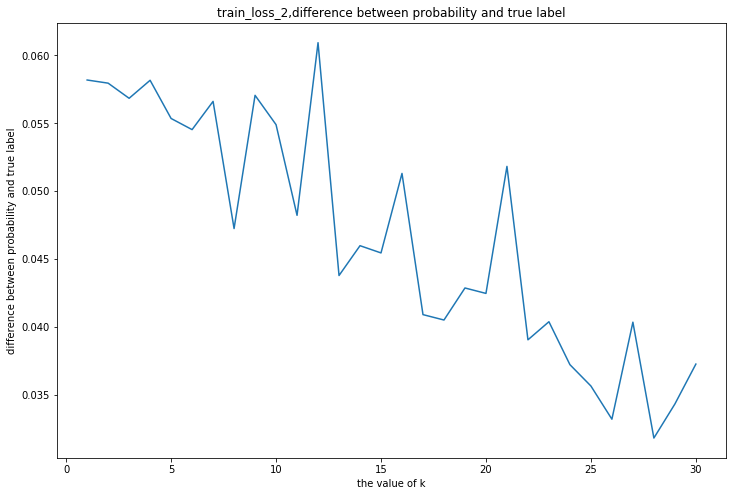

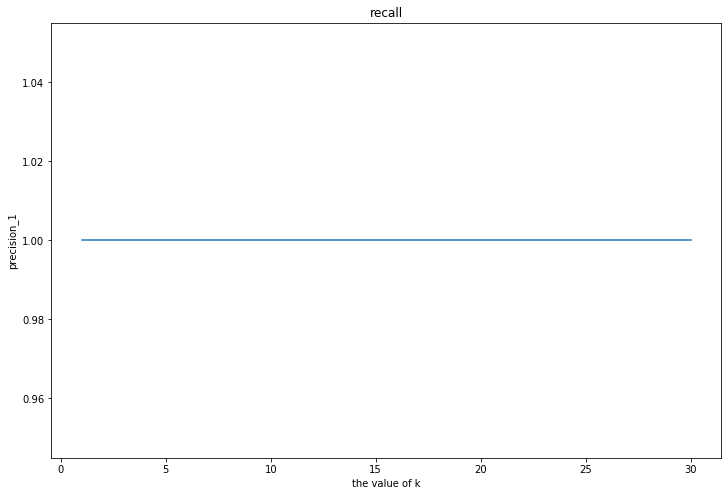

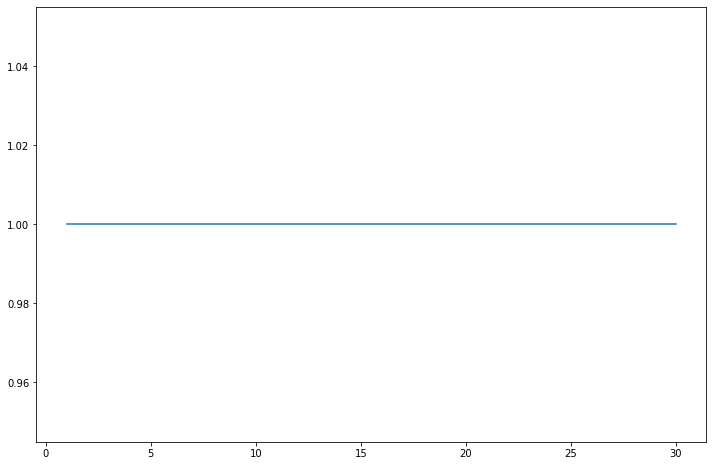

In [8]:
a = autoencoder(num_epochs=6000, denoising=False, masking=0.5, display_step=200)

compressed_training_data = a.compressed_train

original_training_data = a.train

compressed_testing_data = a.compressed_test
original_testing_data = a.test




overall_true_positive = 0
overall_false_negative = 0
overall_false_positive = 0

#n_clusters =20
range_of_cluster = 30
train_loss_1 = []
train_loss_2 = []

recall_list_1 = []
precision_list_1 = []

recall_list_2 = []
precision_list_2 = []

for n_clusters in np.arange(1,range_of_cluster+1):

    estimator,label_pred,centroids = run_kmeans(n_clusters)

    clusters = fill_the_clusters(label_pred)

    loss_difference_between_true_label_and_probability, true_positive_1, false_negative_1, false_positive_1,loss_difference_between_true_label_and_prediction, true_positive_2, false_negative_2, false_positive_2 = calculate_loss(clusters)

    recall_1 = true_positive_1/(true_positive_1+false_negative_1)
    precision_1 = true_positive_1/(true_positive_1+false_positive_1)
    recall_list_1.append(recall_1)
    precision_list_1.append(precision_1)

    recall_2 = true_positive_2 / (true_positive_2 + false_negative_2)
    precision_2 = true_positive_2 / (true_positive_2 + false_positive_2)
    recall_list_2.append(recall_2)
    precision_list_2.append(precision_2)

    l = np.average(loss_difference_between_true_label_and_probability)

    train_loss_1.append(np.average(loss_difference_between_true_label_and_probability))
    train_loss_2.append(np.average(loss_difference_between_true_label_and_prediction))


xs = np.arange(1,range_of_cluster+1)
fig, ax = plt.subplots(figsize=(12, 8))
train_loss_1 = np.reshape(train_loss_1,(range_of_cluster,-1))
ax.plot(xs, train_loss_1)
ax.set_xlabel('the value of k')
ax.set_ylabel('difference between prediction and true label')
ax.title.set_text('train_loss_1,difference between prediction and true label')

fig, bx = plt.subplots(figsize=(12, 8))
train_loss_2 = np.reshape(train_loss_2,(range_of_cluster,-1))
bx.plot(xs, train_loss_2)
bx.set_xlabel('the value of k')
bx.set_ylabel('difference between probability and true label')
bx.title.set_text('train_loss_2,difference between probability and true label')

fig, cx = plt.subplots(figsize=(12, 8))
recall_list_1 = np.reshape(recall_list_1,(range_of_cluster,-1))
cx.plot(xs, recall_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('recall_loss_function1')
cx.title.set_text('recall')
# fig, cx = plt.subplots(figsize=(12, 8))
# recall_list_2 = np.reshape(recall_list_2,(range_of_cluster,-1))
# cx.plot(xs, recall_list_2)
# cx.set_xlabel('the value of k')
# cx.set_ylabel('recall_2')

fig, ax = plt.subplots(figsize=(12, 8))
precision_list_1 = np.reshape(precision_list_1,(range_of_cluster,-1))
ax.plot(xs, precision_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_1')

'''
fig, ax = plt.subplots(figsize=(12, 8))
precision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))
ax.plot(xs, precision_list_2)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_2')
'''



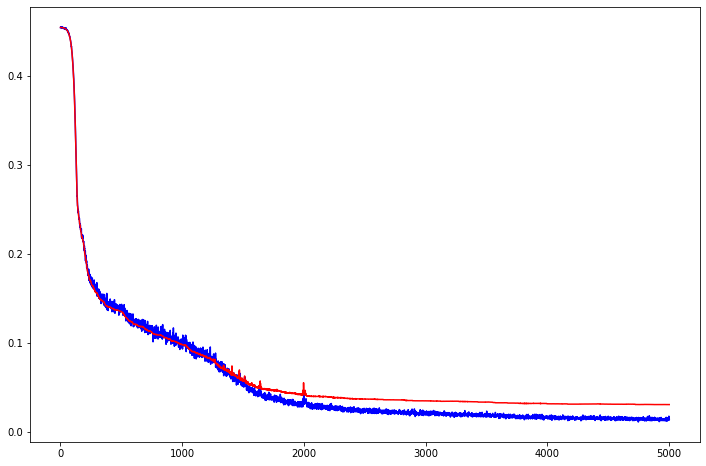

autoencoder finished


"\nfig, ax = plt.subplots(figsize=(12, 8))\nprecision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))\nax.plot(xs, precision_list_2)\ncx.set_xlabel('the value of k')\ncx.set_ylabel('precision_2')\n"

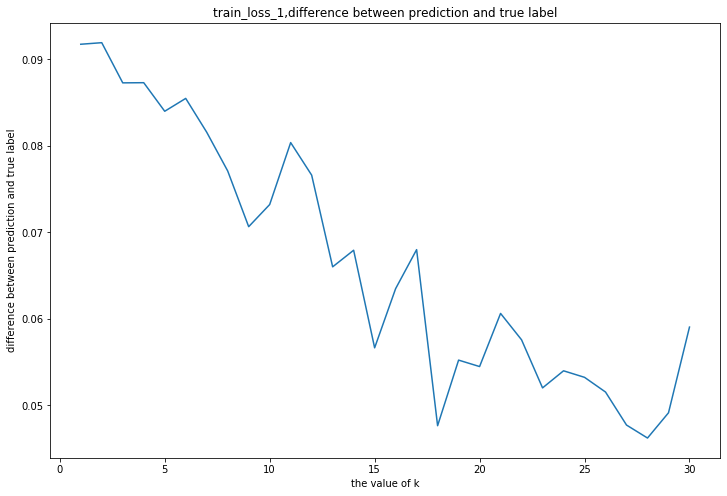

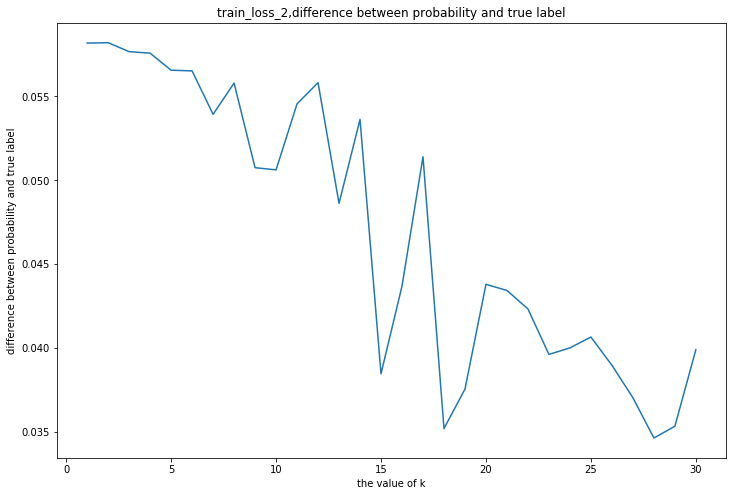

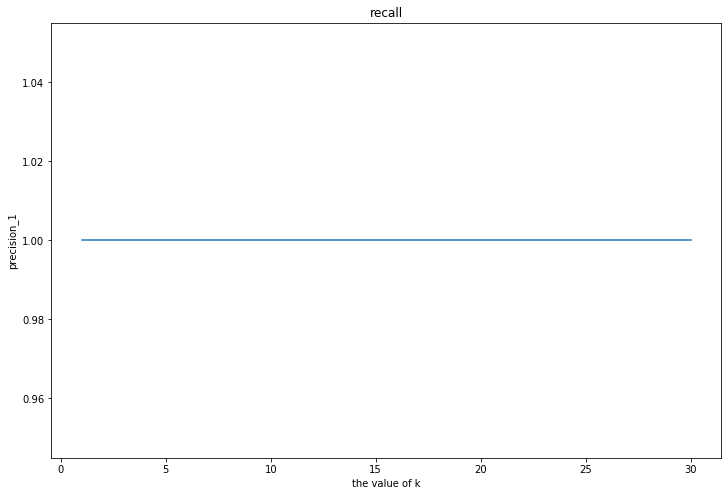

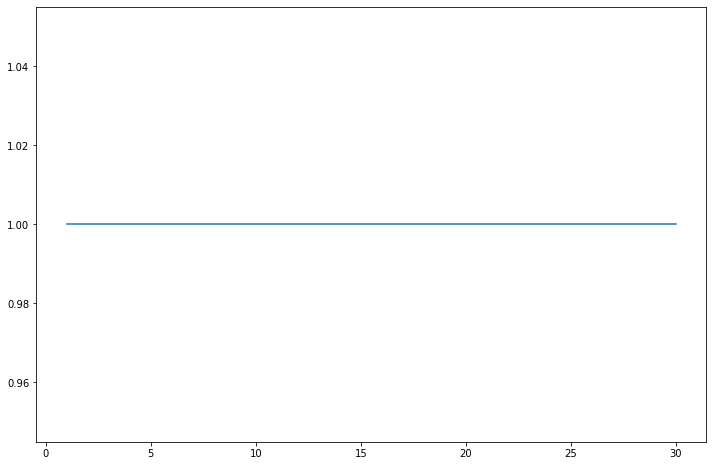

In [9]:
a = autoencoder(num_epochs=5000, denoising=False, masking=0.5, display_step=200)

compressed_training_data = a.compressed_train

original_training_data = a.train

compressed_testing_data = a.compressed_test
original_testing_data = a.test




overall_true_positive = 0
overall_false_negative = 0
overall_false_positive = 0

#n_clusters =20
range_of_cluster = 30
train_loss_1 = []
train_loss_2 = []

recall_list_1 = []
precision_list_1 = []

recall_list_2 = []
precision_list_2 = []

for n_clusters in np.arange(1,range_of_cluster+1):

    estimator,label_pred,centroids = run_kmeans(n_clusters)

    clusters = fill_the_clusters(label_pred)

    loss_difference_between_true_label_and_probability, true_positive_1, false_negative_1, false_positive_1,loss_difference_between_true_label_and_prediction, true_positive_2, false_negative_2, false_positive_2 = calculate_loss(clusters)

    recall_1 = true_positive_1/(true_positive_1+false_negative_1)
    precision_1 = true_positive_1/(true_positive_1+false_positive_1)
    recall_list_1.append(recall_1)
    precision_list_1.append(precision_1)

    recall_2 = true_positive_2 / (true_positive_2 + false_negative_2)
    precision_2 = true_positive_2 / (true_positive_2 + false_positive_2)
    recall_list_2.append(recall_2)
    precision_list_2.append(precision_2)

    l = np.average(loss_difference_between_true_label_and_probability)

    train_loss_1.append(np.average(loss_difference_between_true_label_and_probability))
    train_loss_2.append(np.average(loss_difference_between_true_label_and_prediction))


xs = np.arange(1,range_of_cluster+1)
fig, ax = plt.subplots(figsize=(12, 8))
train_loss_1 = np.reshape(train_loss_1,(range_of_cluster,-1))
ax.plot(xs, train_loss_1)
ax.set_xlabel('the value of k')
ax.set_ylabel('difference between prediction and true label')
ax.title.set_text('train_loss_1,difference between prediction and true label')

fig, bx = plt.subplots(figsize=(12, 8))
train_loss_2 = np.reshape(train_loss_2,(range_of_cluster,-1))
bx.plot(xs, train_loss_2)
bx.set_xlabel('the value of k')
bx.set_ylabel('difference between probability and true label')
bx.title.set_text('train_loss_2,difference between probability and true label')

fig, cx = plt.subplots(figsize=(12, 8))
recall_list_1 = np.reshape(recall_list_1,(range_of_cluster,-1))
cx.plot(xs, recall_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('recall_loss_function1')
cx.title.set_text('recall')
# fig, cx = plt.subplots(figsize=(12, 8))
# recall_list_2 = np.reshape(recall_list_2,(range_of_cluster,-1))
# cx.plot(xs, recall_list_2)
# cx.set_xlabel('the value of k')
# cx.set_ylabel('recall_2')

fig, ax = plt.subplots(figsize=(12, 8))
precision_list_1 = np.reshape(precision_list_1,(range_of_cluster,-1))
ax.plot(xs, precision_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_1')

'''
fig, ax = plt.subplots(figsize=(12, 8))
precision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))
ax.plot(xs, precision_list_2)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_2')
'''



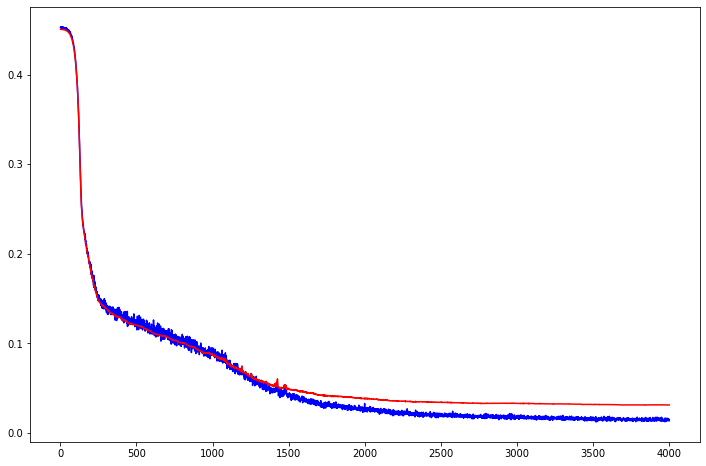

autoencoder finished


"\nfig, ax = plt.subplots(figsize=(12, 8))\nprecision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))\nax.plot(xs, precision_list_2)\ncx.set_xlabel('the value of k')\ncx.set_ylabel('precision_2')\n"

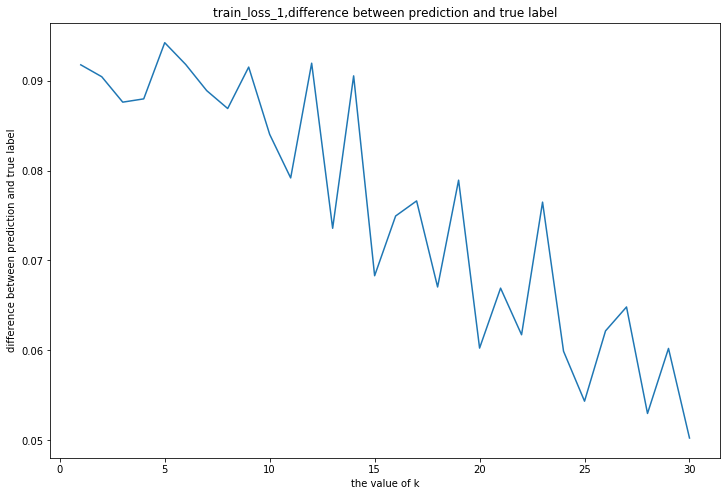

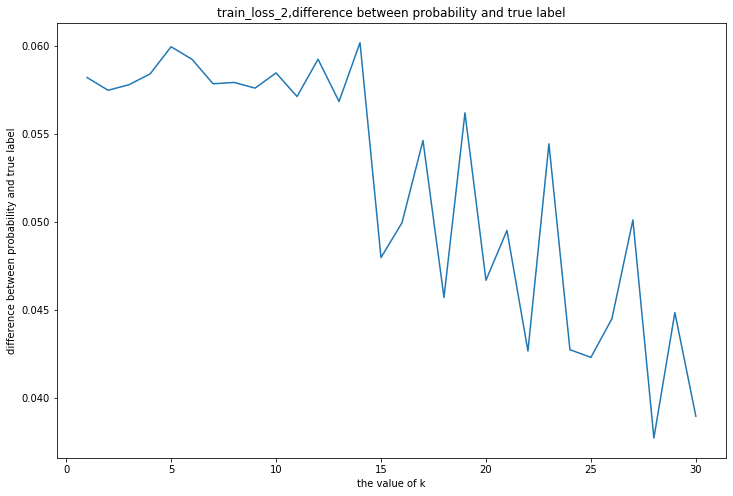

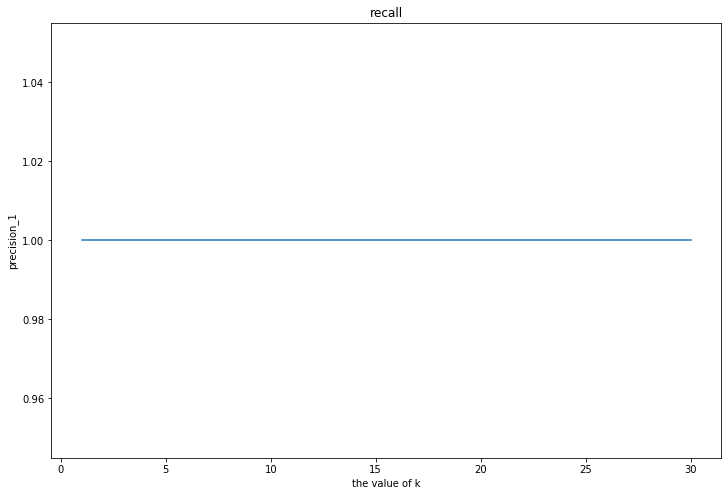

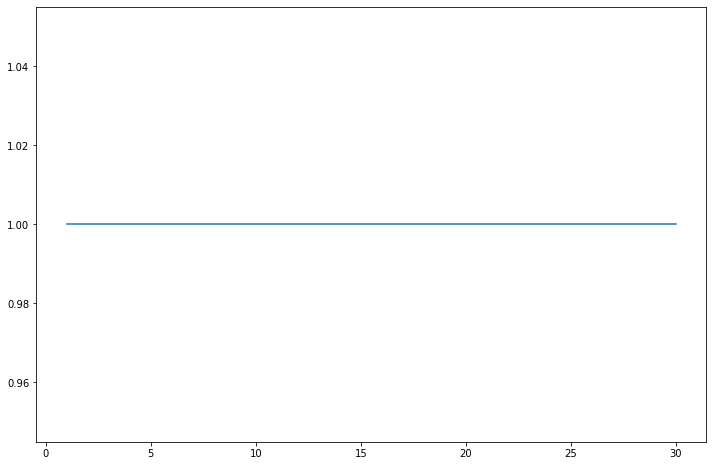

In [10]:
a = autoencoder(num_epochs=4000, denoising=False, masking=0.5, display_step=200)

compressed_training_data = a.compressed_train

original_training_data = a.train

compressed_testing_data = a.compressed_test
original_testing_data = a.test




overall_true_positive = 0
overall_false_negative = 0
overall_false_positive = 0

#n_clusters =20
range_of_cluster = 30
train_loss_1 = []
train_loss_2 = []

recall_list_1 = []
precision_list_1 = []

recall_list_2 = []
precision_list_2 = []

for n_clusters in np.arange(1,range_of_cluster+1):

    estimator,label_pred,centroids = run_kmeans(n_clusters)

    clusters = fill_the_clusters(label_pred)

    loss_difference_between_true_label_and_probability, true_positive_1, false_negative_1, false_positive_1,loss_difference_between_true_label_and_prediction, true_positive_2, false_negative_2, false_positive_2 = calculate_loss(clusters)

    recall_1 = true_positive_1/(true_positive_1+false_negative_1)
    precision_1 = true_positive_1/(true_positive_1+false_positive_1)
    recall_list_1.append(recall_1)
    precision_list_1.append(precision_1)

    recall_2 = true_positive_2 / (true_positive_2 + false_negative_2)
    precision_2 = true_positive_2 / (true_positive_2 + false_positive_2)
    recall_list_2.append(recall_2)
    precision_list_2.append(precision_2)

    l = np.average(loss_difference_between_true_label_and_probability)

    train_loss_1.append(np.average(loss_difference_between_true_label_and_probability))
    train_loss_2.append(np.average(loss_difference_between_true_label_and_prediction))


xs = np.arange(1,range_of_cluster+1)
fig, ax = plt.subplots(figsize=(12, 8))
train_loss_1 = np.reshape(train_loss_1,(range_of_cluster,-1))
ax.plot(xs, train_loss_1)
ax.set_xlabel('the value of k')
ax.set_ylabel('difference between prediction and true label')
ax.title.set_text('train_loss_1,difference between prediction and true label')

fig, bx = plt.subplots(figsize=(12, 8))
train_loss_2 = np.reshape(train_loss_2,(range_of_cluster,-1))
bx.plot(xs, train_loss_2)
bx.set_xlabel('the value of k')
bx.set_ylabel('difference between probability and true label')
bx.title.set_text('train_loss_2,difference between probability and true label')

fig, cx = plt.subplots(figsize=(12, 8))
recall_list_1 = np.reshape(recall_list_1,(range_of_cluster,-1))
cx.plot(xs, recall_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('recall_loss_function1')
cx.title.set_text('recall')
# fig, cx = plt.subplots(figsize=(12, 8))
# recall_list_2 = np.reshape(recall_list_2,(range_of_cluster,-1))
# cx.plot(xs, recall_list_2)
# cx.set_xlabel('the value of k')
# cx.set_ylabel('recall_2')

fig, ax = plt.subplots(figsize=(12, 8))
precision_list_1 = np.reshape(precision_list_1,(range_of_cluster,-1))
ax.plot(xs, precision_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_1')

'''
fig, ax = plt.subplots(figsize=(12, 8))
precision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))
ax.plot(xs, precision_list_2)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_2')
'''



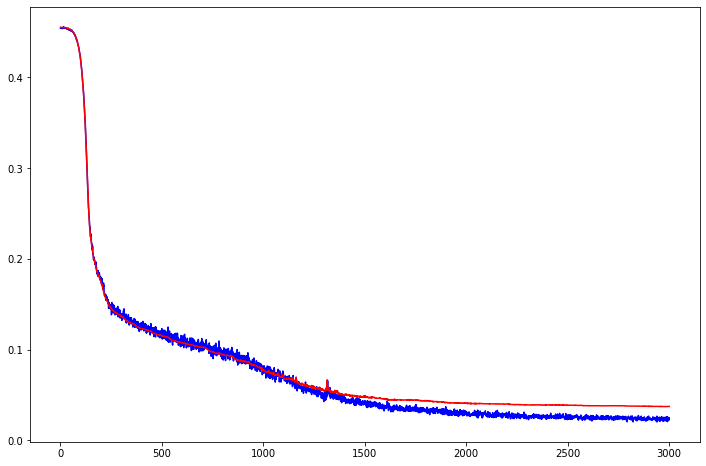

autoencoder finished


"\nfig, ax = plt.subplots(figsize=(12, 8))\nprecision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))\nax.plot(xs, precision_list_2)\ncx.set_xlabel('the value of k')\ncx.set_ylabel('precision_2')\n"

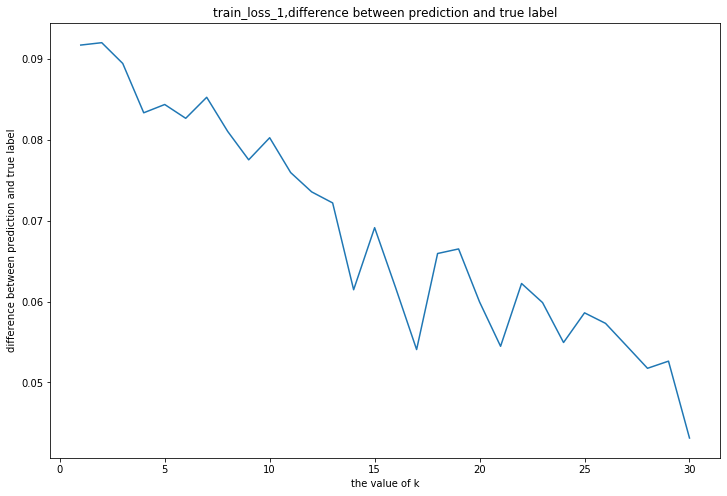

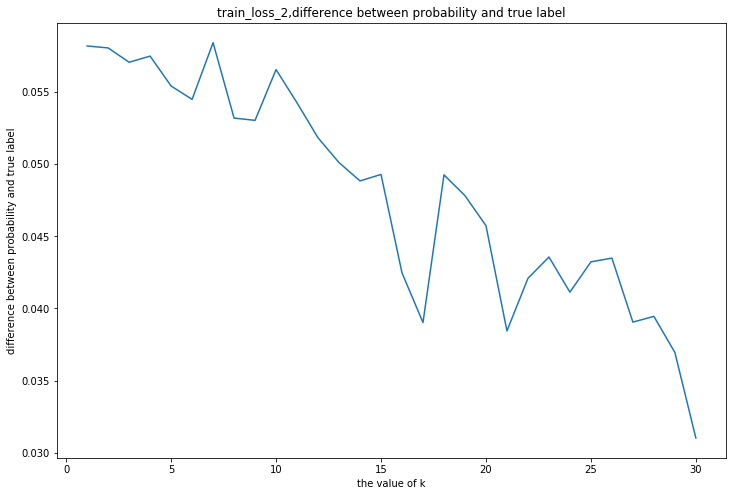

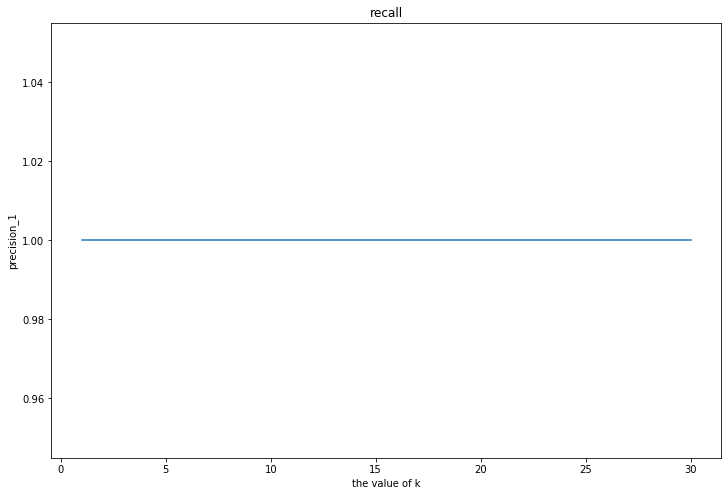

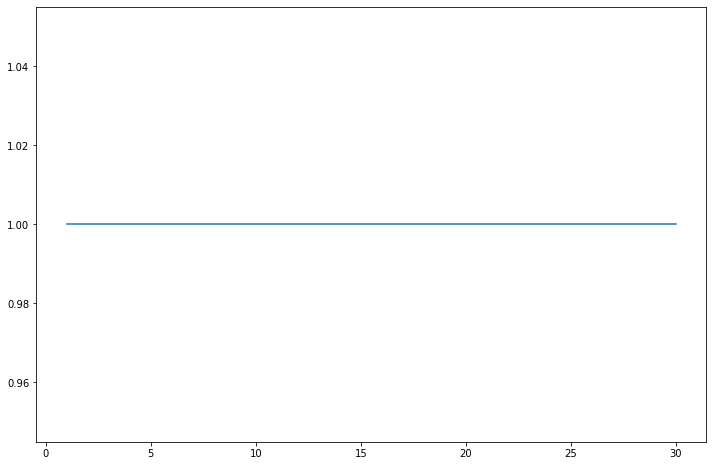

In [11]:
a = autoencoder(num_epochs=3000, denoising=False, masking=0.5, display_step=200)

compressed_training_data = a.compressed_train

original_training_data = a.train

compressed_testing_data = a.compressed_test
original_testing_data = a.test




overall_true_positive = 0
overall_false_negative = 0
overall_false_positive = 0

#n_clusters =20
range_of_cluster = 30
train_loss_1 = []
train_loss_2 = []

recall_list_1 = []
precision_list_1 = []

recall_list_2 = []
precision_list_2 = []

for n_clusters in np.arange(1,range_of_cluster+1):

    estimator,label_pred,centroids = run_kmeans(n_clusters)

    clusters = fill_the_clusters(label_pred)

    loss_difference_between_true_label_and_probability, true_positive_1, false_negative_1, false_positive_1,loss_difference_between_true_label_and_prediction, true_positive_2, false_negative_2, false_positive_2 = calculate_loss(clusters)

    recall_1 = true_positive_1/(true_positive_1+false_negative_1)
    precision_1 = true_positive_1/(true_positive_1+false_positive_1)
    recall_list_1.append(recall_1)
    precision_list_1.append(precision_1)

    recall_2 = true_positive_2 / (true_positive_2 + false_negative_2)
    precision_2 = true_positive_2 / (true_positive_2 + false_positive_2)
    recall_list_2.append(recall_2)
    precision_list_2.append(precision_2)

    l = np.average(loss_difference_between_true_label_and_probability)

    train_loss_1.append(np.average(loss_difference_between_true_label_and_probability))
    train_loss_2.append(np.average(loss_difference_between_true_label_and_prediction))


xs = np.arange(1,range_of_cluster+1)
fig, ax = plt.subplots(figsize=(12, 8))
train_loss_1 = np.reshape(train_loss_1,(range_of_cluster,-1))
ax.plot(xs, train_loss_1)
ax.set_xlabel('the value of k')
ax.set_ylabel('difference between prediction and true label')
ax.title.set_text('train_loss_1,difference between prediction and true label')

fig, bx = plt.subplots(figsize=(12, 8))
train_loss_2 = np.reshape(train_loss_2,(range_of_cluster,-1))
bx.plot(xs, train_loss_2)
bx.set_xlabel('the value of k')
bx.set_ylabel('difference between probability and true label')
bx.title.set_text('train_loss_2,difference between probability and true label')

fig, cx = plt.subplots(figsize=(12, 8))
recall_list_1 = np.reshape(recall_list_1,(range_of_cluster,-1))
cx.plot(xs, recall_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('recall_loss_function1')
cx.title.set_text('recall')
# fig, cx = plt.subplots(figsize=(12, 8))
# recall_list_2 = np.reshape(recall_list_2,(range_of_cluster,-1))
# cx.plot(xs, recall_list_2)
# cx.set_xlabel('the value of k')
# cx.set_ylabel('recall_2')

fig, ax = plt.subplots(figsize=(12, 8))
precision_list_1 = np.reshape(precision_list_1,(range_of_cluster,-1))
ax.plot(xs, precision_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_1')

'''
fig, ax = plt.subplots(figsize=(12, 8))
precision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))
ax.plot(xs, precision_list_2)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_2')
'''



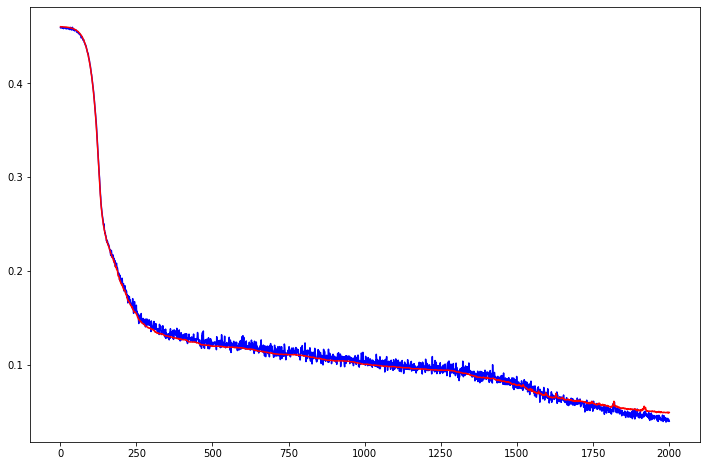

autoencoder finished


"\nfig, ax = plt.subplots(figsize=(12, 8))\nprecision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))\nax.plot(xs, precision_list_2)\ncx.set_xlabel('the value of k')\ncx.set_ylabel('precision_2')\n"

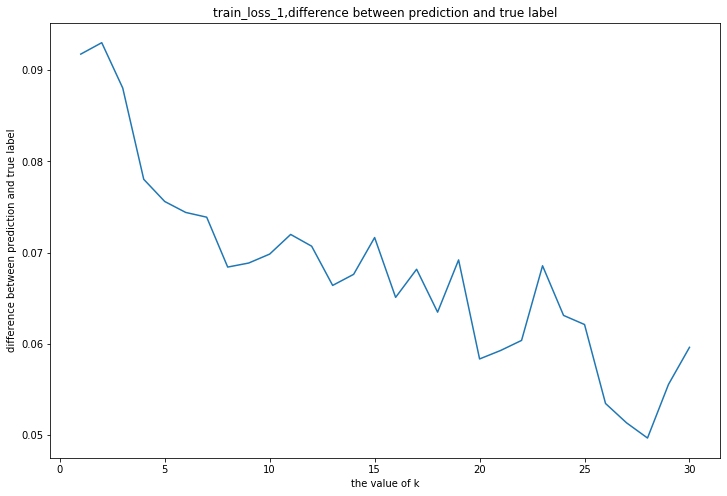

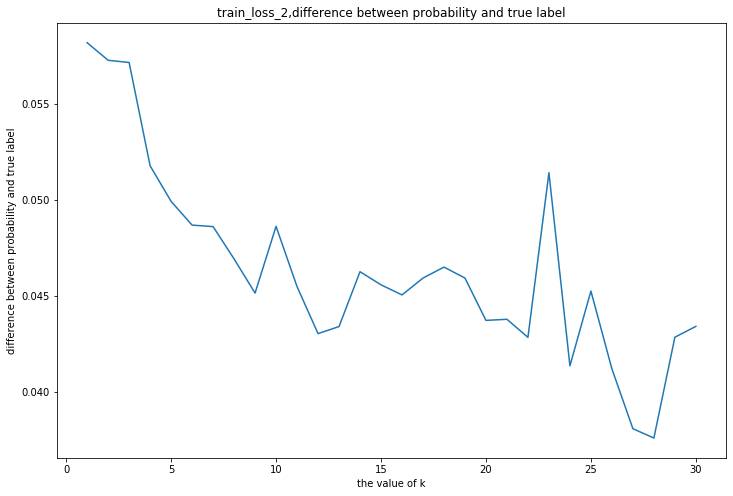

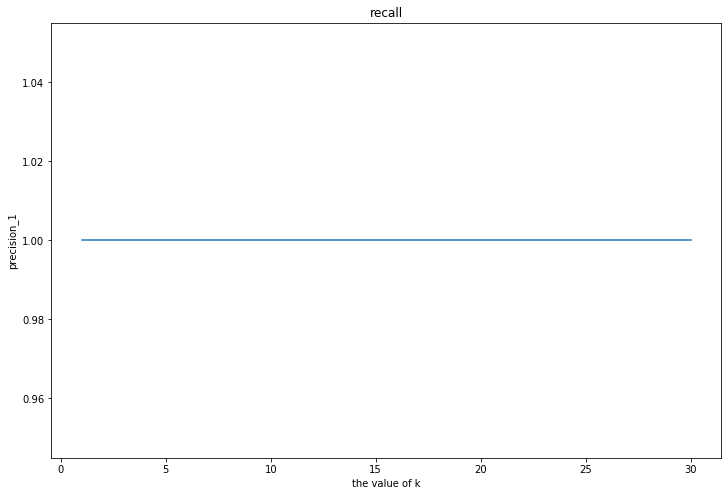

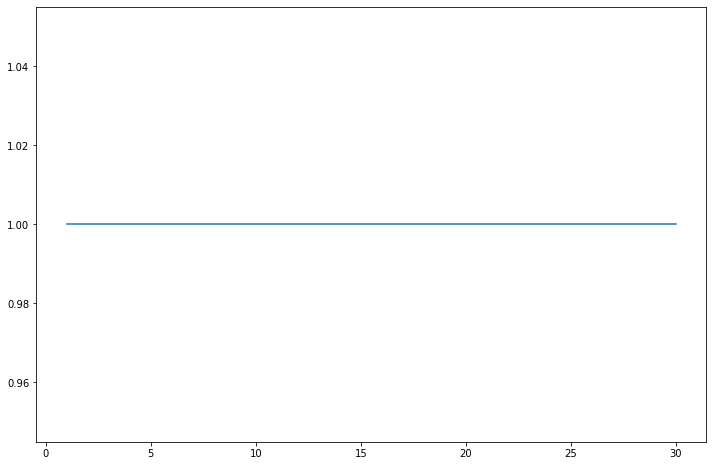

In [12]:
a = autoencoder(num_epochs=2000, denoising=False, masking=0.5, display_step=200)

compressed_training_data = a.compressed_train

original_training_data = a.train

compressed_testing_data = a.compressed_test
original_testing_data = a.test




overall_true_positive = 0
overall_false_negative = 0
overall_false_positive = 0

#n_clusters =20
range_of_cluster = 30
train_loss_1 = []
train_loss_2 = []

recall_list_1 = []
precision_list_1 = []

recall_list_2 = []
precision_list_2 = []

for n_clusters in np.arange(1,range_of_cluster+1):

    estimator,label_pred,centroids = run_kmeans(n_clusters)

    clusters = fill_the_clusters(label_pred)

    loss_difference_between_true_label_and_probability, true_positive_1, false_negative_1, false_positive_1,loss_difference_between_true_label_and_prediction, true_positive_2, false_negative_2, false_positive_2 = calculate_loss(clusters)

    recall_1 = true_positive_1/(true_positive_1+false_negative_1)
    precision_1 = true_positive_1/(true_positive_1+false_positive_1)
    recall_list_1.append(recall_1)
    precision_list_1.append(precision_1)

    recall_2 = true_positive_2 / (true_positive_2 + false_negative_2)
    precision_2 = true_positive_2 / (true_positive_2 + false_positive_2)
    recall_list_2.append(recall_2)
    precision_list_2.append(precision_2)

    l = np.average(loss_difference_between_true_label_and_probability)

    train_loss_1.append(np.average(loss_difference_between_true_label_and_probability))
    train_loss_2.append(np.average(loss_difference_between_true_label_and_prediction))


xs = np.arange(1,range_of_cluster+1)
fig, ax = plt.subplots(figsize=(12, 8))
train_loss_1 = np.reshape(train_loss_1,(range_of_cluster,-1))
ax.plot(xs, train_loss_1)
ax.set_xlabel('the value of k')
ax.set_ylabel('difference between prediction and true label')
ax.title.set_text('train_loss_1,difference between prediction and true label')

fig, bx = plt.subplots(figsize=(12, 8))
train_loss_2 = np.reshape(train_loss_2,(range_of_cluster,-1))
bx.plot(xs, train_loss_2)
bx.set_xlabel('the value of k')
bx.set_ylabel('difference between probability and true label')
bx.title.set_text('train_loss_2,difference between probability and true label')

fig, cx = plt.subplots(figsize=(12, 8))
recall_list_1 = np.reshape(recall_list_1,(range_of_cluster,-1))
cx.plot(xs, recall_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('recall_loss_function1')
cx.title.set_text('recall')
# fig, cx = plt.subplots(figsize=(12, 8))
# recall_list_2 = np.reshape(recall_list_2,(range_of_cluster,-1))
# cx.plot(xs, recall_list_2)
# cx.set_xlabel('the value of k')
# cx.set_ylabel('recall_2')

fig, ax = plt.subplots(figsize=(12, 8))
precision_list_1 = np.reshape(precision_list_1,(range_of_cluster,-1))
ax.plot(xs, precision_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_1')

'''
fig, ax = plt.subplots(figsize=(12, 8))
precision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))
ax.plot(xs, precision_list_2)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_2')
'''



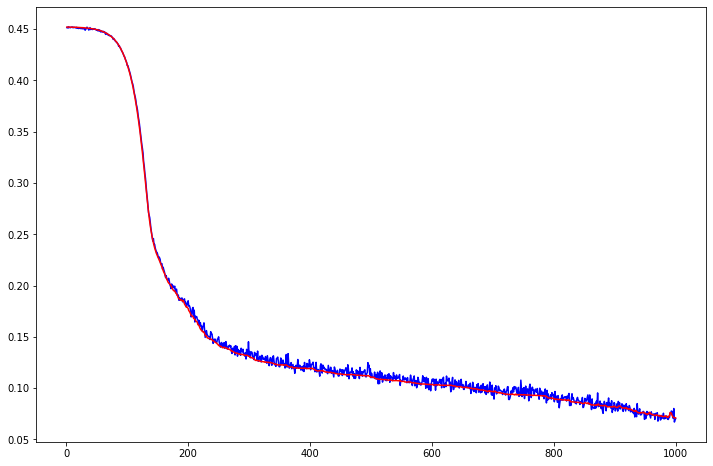

autoencoder finished


"\nfig, ax = plt.subplots(figsize=(12, 8))\nprecision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))\nax.plot(xs, precision_list_2)\ncx.set_xlabel('the value of k')\ncx.set_ylabel('precision_2')\n"

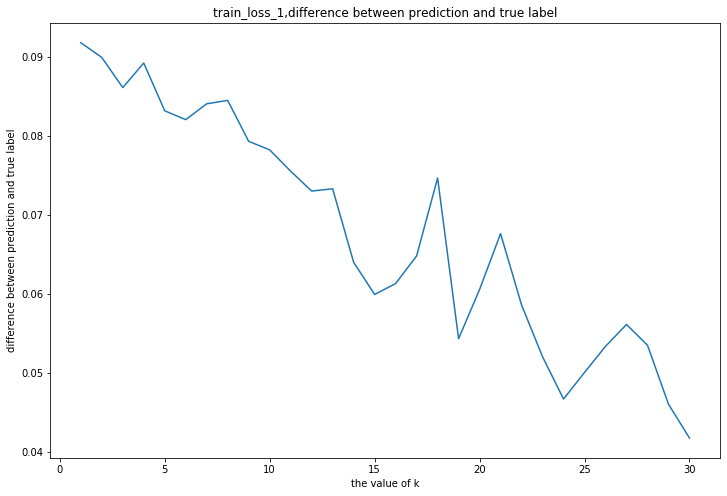

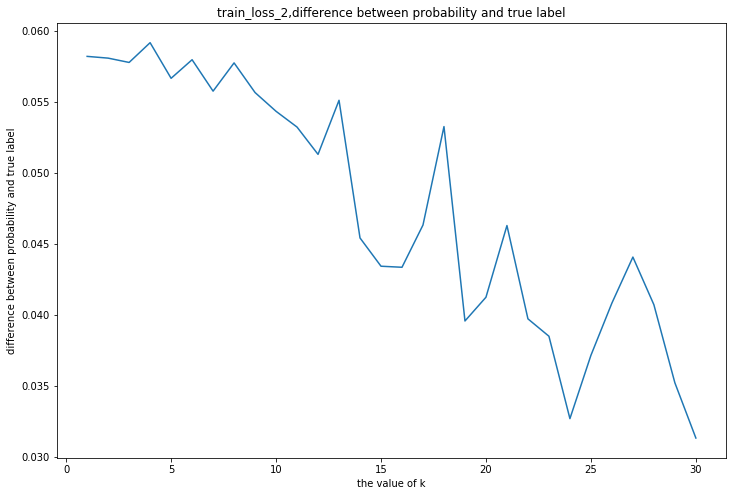

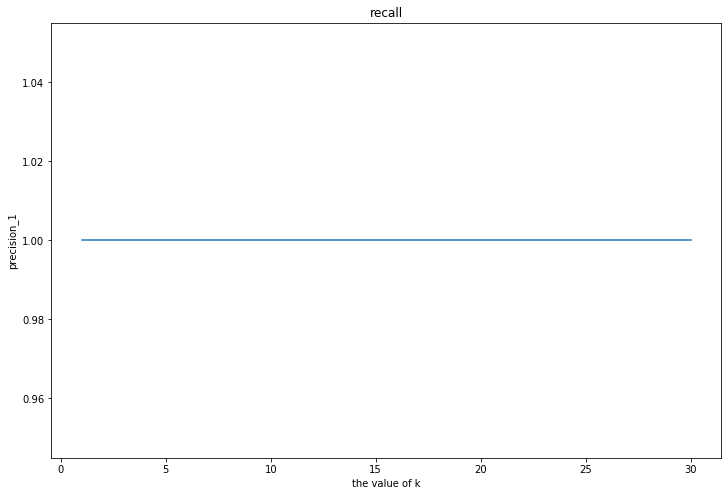

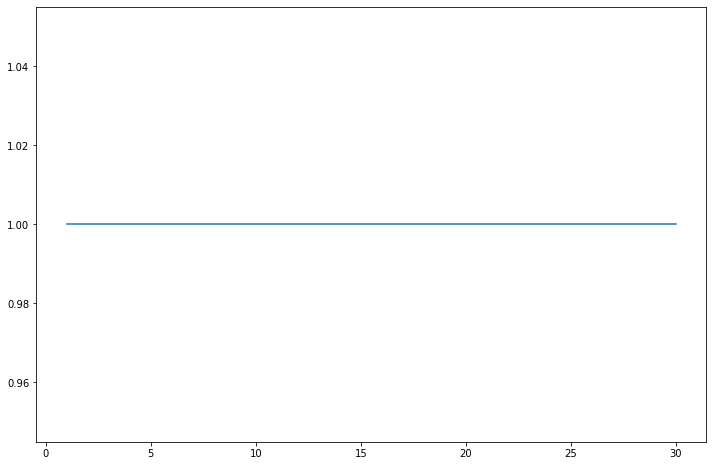

In [14]:
a = autoencoder(num_epochs=1000, denoising=False, masking=0.5, display_step=200)

compressed_training_data = a.compressed_train

original_training_data = a.train

compressed_testing_data = a.compressed_test
original_testing_data = a.test




overall_true_positive = 0
overall_false_negative = 0
overall_false_positive = 0

#n_clusters =20
range_of_cluster = 30
train_loss_1 = []
train_loss_2 = []

recall_list_1 = []
precision_list_1 = []

recall_list_2 = []
precision_list_2 = []

for n_clusters in np.arange(1,range_of_cluster+1):

    estimator,label_pred,centroids = run_kmeans(n_clusters)

    clusters = fill_the_clusters(label_pred)

    loss_difference_between_true_label_and_probability, true_positive_1, false_negative_1, false_positive_1,loss_difference_between_true_label_and_prediction, true_positive_2, false_negative_2, false_positive_2 = calculate_loss(clusters)

    recall_1 = true_positive_1/(true_positive_1+false_negative_1)
    precision_1 = true_positive_1/(true_positive_1+false_positive_1)
    recall_list_1.append(recall_1)
    precision_list_1.append(precision_1)

    recall_2 = true_positive_2 / (true_positive_2 + false_negative_2)
    precision_2 = true_positive_2 / (true_positive_2 + false_positive_2)
    recall_list_2.append(recall_2)
    precision_list_2.append(precision_2)

    l = np.average(loss_difference_between_true_label_and_probability)

    train_loss_1.append(np.average(loss_difference_between_true_label_and_probability))
    train_loss_2.append(np.average(loss_difference_between_true_label_and_prediction))


xs = np.arange(1,range_of_cluster+1)
fig, ax = plt.subplots(figsize=(12, 8))
train_loss_1 = np.reshape(train_loss_1,(range_of_cluster,-1))
ax.plot(xs, train_loss_1)
ax.set_xlabel('the value of k')
ax.set_ylabel('difference between prediction and true label')
ax.title.set_text('train_loss_1,difference between prediction and true label')

fig, bx = plt.subplots(figsize=(12, 8))
train_loss_2 = np.reshape(train_loss_2,(range_of_cluster,-1))
bx.plot(xs, train_loss_2)
bx.set_xlabel('the value of k')
bx.set_ylabel('difference between probability and true label')
bx.title.set_text('train_loss_2,difference between probability and true label')

fig, cx = plt.subplots(figsize=(12, 8))
recall_list_1 = np.reshape(recall_list_1,(range_of_cluster,-1))
cx.plot(xs, recall_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('recall_loss_function1')
cx.title.set_text('recall')
# fig, cx = plt.subplots(figsize=(12, 8))
# recall_list_2 = np.reshape(recall_list_2,(range_of_cluster,-1))
# cx.plot(xs, recall_list_2)
# cx.set_xlabel('the value of k')
# cx.set_ylabel('recall_2')

fig, ax = plt.subplots(figsize=(12, 8))
precision_list_1 = np.reshape(precision_list_1,(range_of_cluster,-1))
ax.plot(xs, precision_list_1)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_1')

'''
fig, ax = plt.subplots(figsize=(12, 8))
precision_list_2 = np.reshape(precision_list_2,(range_of_cluster,-1))
ax.plot(xs, precision_list_2)
cx.set_xlabel('the value of k')
cx.set_ylabel('precision_2')
'''

